### Preparación entorno

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
WORKING_PATH = '/content/drive/MyDrive/KeepCoding/DeepLearning/exercise'


In [ ]:
%cd {WORKING_PATH}

/content/drive/MyDrive/KeepCoding/DeepLearning/exercise


In [ ]:
!pip install -r requirements.tx
#!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.3 MB/s eta 0:00:00


In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib as plt
import os
import torch
from torch.utils.data import TensorDataset
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import optuna

In [ ]:
# to load custom libraries
sys.path.append(WORKING_PATH)

# load custom libraries
from utilsTrain import *
from utilsDataset import *
from utilsNN import *
from utilsOptuna import *
from utils import *

### Procesado de datos

In [ ]:
# load dataset
poi_data = pd.read_csv(os.path.join(WORKING_PATH, "poi_dataset.csv"))

set_random_seed()

In [ ]:
# split data into train, val and test datasets
df_train, df_test = train_test_split(poi_data, test_size = 0.2, random_state = 16)
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 16)
print(f'Number of samples.')
print(f'Train dataset: {df_train.shape[0]}')
print(f'Validation dataset: {df_val.shape[0]}')
print(f'Test dataset: {df_test.shape[0]}')

Number of samples.
Train dataset: 1004
Validation dataset: 251
Test dataset: 314


In [ ]:
# calculate engagement score
df_engagement = df_train[['Visits','Bookmarks','Likes','Dislikes']].copy()
df_engagement['Likes_Dislikes'] = df_engagement['Likes'] - df_engagement['Dislikes']
df_engagement = df_engagement[['Visits','Likes_Dislikes']]
scaler_engagement = MinMaxScaler().fit(df_engagement)

# Calculate scores
def categorize_score(x):
  if x < 0.29:
    return 0
  else:
    return 1


In [ ]:
# Normalize xps, locationLon, locationLat, numTags
scaler_features = StandardScaler().fit(df_train[['xps','locationLon','locationLat']])

# one hot encoder for categories
onehot_encoder_categories = MultiLabelBinarizer().fit(poi_data['categories'].apply(eval))

# One hot encoder for tier
onehot_encoder_tier = OneHotEncoder(sparse_output=False).fit(pd.DataFrame(poi_data['tier']))


In [ ]:
def processdata(df):
  """
  Data processing steps before being used in the model.
  Same steps are applied to train, validation and test datasets.
  Processing include:
  - Calculate number of tags
  - One hot encoding for categories
  - Calculate engagement feature (low, medium, high)
  - Scale quantitative features
  - One hot encoding for tier
  - Remove features
  """
  df.index = range(df.shape[0])
  # Feature for number of tags
  df['NumTags'] = df['tags'].apply(eval).apply(len)
  # One hot encoder for categories
  categories_one_hot = onehot_encoder_categories.transform(df['categories'].apply(eval))
  df_categories_one_hot = pd.DataFrame(categories_one_hot, columns=onehot_encoder_categories.classes_)
  df = pd.concat([df, df_categories_one_hot], axis=1)
  # Engagement features
  df['Likes_Dislikes'] = df['Likes'] - df['Dislikes']
  df_engagement = df[['Visits','Likes_Dislikes']]
  df['Score']= scaler_engagement.transform(df_engagement).sum(axis = 1)/2
  df['engagement'] = df['Score'].apply(categorize_score)
  # Scale features xps, locationLon, locationLat
  df[['xps','locationLon','locationLat']] = scaler_features.transform(df[['xps','locationLon','locationLat']])
  # One hot encoder for tier
  tier_one_hot = onehot_encoder_tier.transform(pd.DataFrame(df['tier']))
  df_tier_one_hot = pd.DataFrame(tier_one_hot, columns=onehot_encoder_tier.get_feature_names_out(['tier']))
  df = pd.concat([df, df_tier_one_hot], axis=1)
  # Remove features
  df_clean = df.drop(['tags','categories','id','name','shortDescription',
                      'Likes','Dislikes','Bookmarks','Visits','Score', 'Likes_Dislikes', 'tier'], axis = 1)
  return df_clean

In [ ]:
# apply data processing steps to train, validation and test data
df_train_proc = processdata(df_train)
df_val_proc = processdata(df_val)
df_test_proc = processdata(df_test)

In [ ]:
df_train_proc.head().T
#df_train_proc.shape

,0,1,2,3,4
locationLon,-0.12049,-0.117211,0.105835,0.781224,-0.122874
locationLat,0.047806,0.045798,1.14064,0.629218,0.044949
xps,0.242539,-0.651893,1.13697,1.13697,-1.99354
main_image_path,data_main/44a58920-7f9c-4f6c-ac38-cf31bb1f04b4...,data_main/07ee926e-f872-4ded-90bf-4214f3072949...,data_main/1728c4c3-7655-497c-b4ef-76d430ee2044...,data_main/647158a1-6409-4af6-b7e1-061fddb4d245...,data_main/4663d5c0-37ed-44ee-a767-d339f0012836...
NumTags,13,13,1,1,10
Arquitectura,1,0,1,0,0
Ciencia,0,0,0,0,0
Cine,0,0,0,0,0
Cultura,0,1,1,1,1
Escultura,0,1,0,0,1


In [ ]:
# Calculate mean and std for each channel of images from train dataset
# This will be used for normalization after transform to tensor
images = read_images(df_train_proc['main_image_path'])
# Normalize to [0, 1] range
images = images / 255.0
# Calculate mean and std over all images and pixels
means = np.mean(images, axis=(0, 1, 2))  # Shape: (3,)
stds = np.std(images, axis=(0, 1, 2))    # Shape: (3,)

100%|██████████| 1004/1004 [04:46<00:00,  3.51it/s]


### Fully-connected neuronal network

In [ ]:
# Parameters to save results
outputdir = '1_FCNN_1'
study_id = 'fcnn_1'
if not os.path.exists(outputdir):
  os.makedirs(outputdir)

In [ ]:
# Prepare Dataset
train_dataset = meta_Dataset(df_train_proc['engagement'], df_train_proc.drop(['engagement','main_image_path'], axis=1))
val_dataset = meta_Dataset(df_val_proc['engagement'], df_val_proc.drop(['engagement','main_image_path'], axis=1))
test_dataset = meta_Dataset(df_test_proc['engagement'], df_test_proc.drop(['engagement','main_image_path'], axis=1))

In [ ]:
# Neural network configuration
num_epochs = 10
criterion = nn.CrossEntropyLoss()

Device: cpu
Epoch 1, Loss: 0.8678378015756607, Acc: 60.1593625498008, Val Loss: 0.7567035853862762, Val Acc: 53.386454183266935, LR: 0.01
Epoch 2, Loss: 0.67827058583498, Acc: 65.93625498007968, Val Loss: 0.6832247674465179, Val Acc: 61.75298804780876, LR: 0.01
Epoch 3, Loss: 0.6548703089356422, Acc: 66.93227091633466, Val Loss: 0.6690332889556885, Val Acc: 63.745019920318725, LR: 0.01
Epoch 4, Loss: 0.6353323236107826, Acc: 68.72509960159363, Val Loss: 0.6542129516601562, Val Acc: 64.9402390438247, LR: 0.01
Epoch 5, Loss: 0.6295286938548088, Acc: 68.12749003984064, Val Loss: 0.6599036157131195, Val Acc: 64.54183266932272, LR: 0.01
Epoch 6, Loss: 0.6296395286917686, Acc: 68.12749003984064, Val Loss: 0.6502631306648254, Val Acc: 64.14342629482071, LR: 0.01
Epoch 7, Loss: 0.6204415187239647, Acc: 68.42629482071713, Val Loss: 0.6514174938201904, Val Acc: 64.54183266932272, LR: 0.01
Epoch 8, Loss: 0.6249206811189651, Acc: 67.62948207171314, Val Loss: 0.6535622775554657, Val Acc: 64.1434262

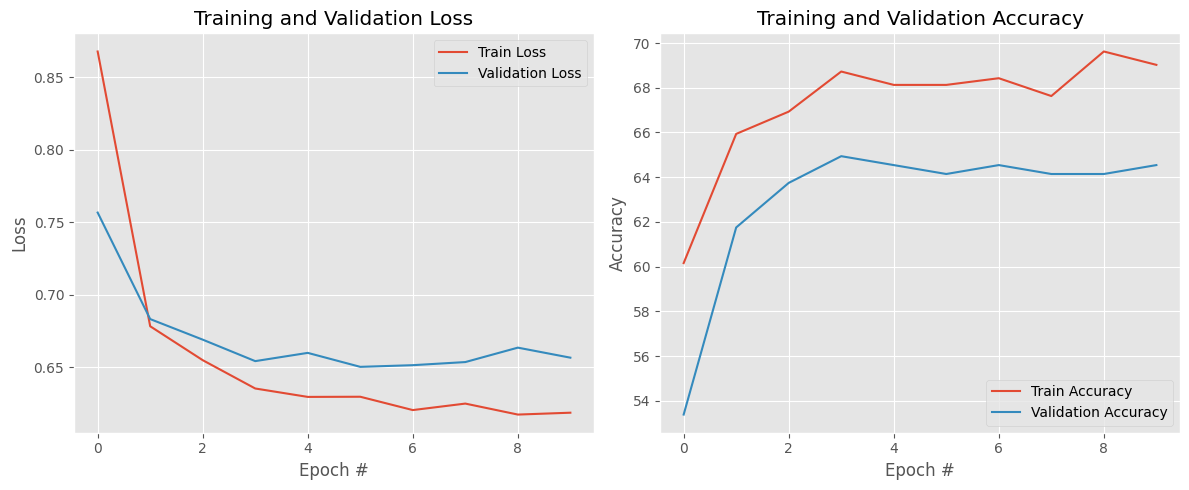

In [ ]:
# train model (check if configuration is ok)
set_random_seed()
learning_rate = 0.01 # To optimize
dropout_rate = 0.2 # To optimize
batch_size = 128 # To optimize
model = FCNN(dropout_rate) # Optimized parameter
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device)

In [ ]:
def objective(trial, to_optim = None):
    """
    Objective function for hyperparameter optimization with Optuna.
    """

    # seed for random numbers
    set_random_seed()

    # hyperparameters to optimize
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5) # To optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True) # To optimize
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256]) # To optimize

    model = FCNN(dropout_rate) # Optimized parameter
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter

    # train model
    train_results = train_model(model, criterion, optimizer, num_epochs,
                                train_loader, val_loader, device, verbose = False)

    # save metrics
    save_metrics_optuna(trial, train_results, outputdir)

    return train_results['val_accs'][-1]

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna_init(sampler, outputdir, study_id)

[I 2025-06-14 12:33:37,554] A new study created in RDB with name: fcnn_1_optimization


In [ ]:
# Optuna optimization
n_trials = 24
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=n_trials, show_progress_bar = True)
optuna_results(study)

  0%|          | 0/24 [00:00<?, ?it/s]

Best trial:
  Value:  65.73705179282868
  Params: 
			Value		Importance 
    dropout_rate:	0.00366		0.31
    learning_rate:	0.00863		0.63
    batch_size:	128.00000		0.06


Confussion matrix:
[[ 68  81]
 [ 24 141]]

Classification report
              precision    recall  f1-score   support

         0.0       0.74      0.46      0.56       149
         1.0       0.64      0.85      0.73       165

    accuracy                           0.67       314
   macro avg       0.69      0.66      0.65       314
weighted avg       0.68      0.67      0.65       314

Accuracy score: 0.67


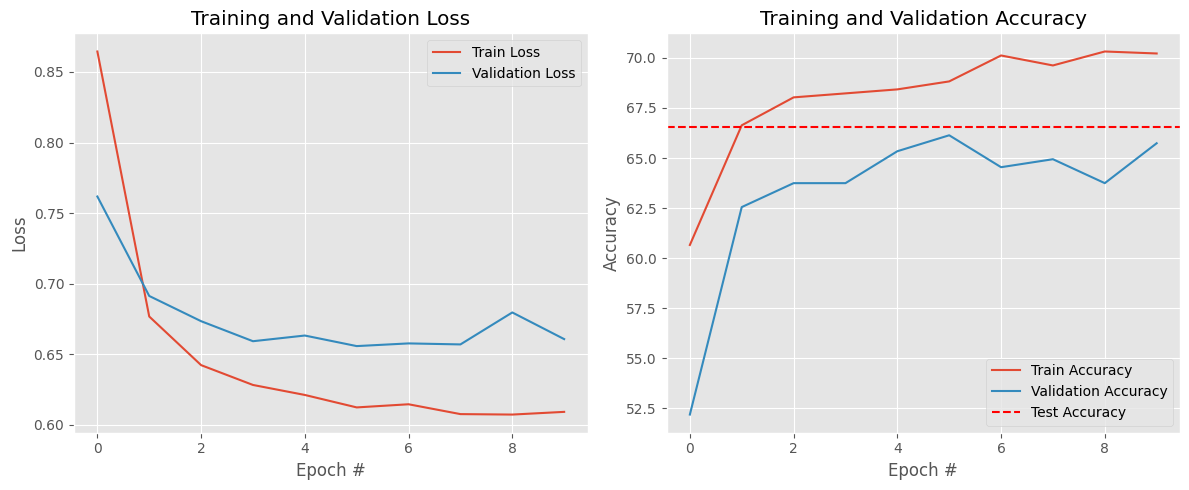

In [ ]:
# train final model
set_random_seed()
dropout_rate = study.best_params.get('dropout_rate') # To optimize
learning_rate = study.best_params.get('learning_rate') # To optimize
batch_size = study.best_params.get('batch_size') # To optimize
model = FCNN(dropout_rate) # Optimized parameter
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, testloader = test_loader, verbose = False)

In [ ]:
# save model
torch.save(model, os.path.join(outputdir, study_id + '_model.pth'))

### Convolutional neuronal network

In [ ]:
# Parameters to save results
outputdir = '2_CNN_1'
study_id = 'cnn_1'
if not os.path.exists(outputdir):
  os.makedirs(outputdir)

In [ ]:
# Prepare Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

train_dataset = img_Dataset(df_train_proc['engagement'], df_train_proc['main_image_path'], transform = transform)
val_dataset = img_Dataset(df_val_proc['engagement'], df_val_proc['main_image_path'], transform = transform)
test_dataset = img_Dataset(df_test_proc['engagement'], df_test_proc['main_image_path'], transform = transform)

In [ ]:
# Neural network configuration
num_epochs = 10
criterion = nn.CrossEntropyLoss()

Device: cpu
Epoch 1, Loss: 1.0614951625466347, Acc: 44.123505976095615, Val Loss: 0.932275116443634, Val Acc: 55.776892430278885, LR: 0.01
Epoch 2, Loss: 0.8589803650975227, Acc: 54.68127490039841, Val Loss: 0.8049123883247375, Val Acc: 45.418326693227094, LR: 0.01
Epoch 3, Loss: 0.7878126427531242, Acc: 58.764940239043824, Val Loss: 0.7497402727603912, Val Acc: 50.199203187250994, LR: 0.01
Epoch 4, Loss: 0.7496872395277023, Acc: 58.56573705179283, Val Loss: 0.7253625690937042, Val Acc: 55.776892430278885, LR: 0.01
Epoch 5, Loss: 0.7298615872859955, Acc: 57.669322709163346, Val Loss: 0.7188962697982788, Val Acc: 55.776892430278885, LR: 0.01
Epoch 6, Loss: 0.7040423080325127, Acc: 58.46613545816733, Val Loss: 0.7057553827762604, Val Acc: 56.57370517928287, LR: 0.01
Epoch 7, Loss: 0.7030952200293541, Acc: 58.366533864541836, Val Loss: 0.7008095383644104, Val Acc: 54.9800796812749, LR: 0.01
Epoch 8, Loss: 0.6973365470767021, Acc: 59.16334661354582, Val Loss: 0.7040722966194153, Val Acc: 5

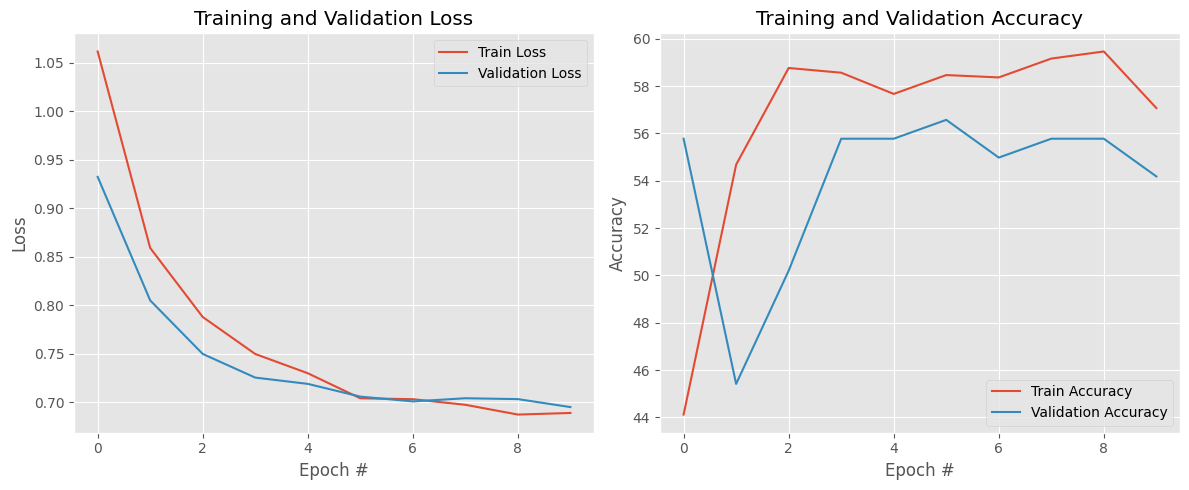

In [ ]:
# train model (check if configuration is ok)
set_random_seed()
learning_rate = 0.01 # To optimize
dropout_rate = 0.2 # To optimize
batch_size = 128 # To optimize
model = CNN(dropout_rate) # Optimized parameter
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device)

In [ ]:
def objective(trial, to_optim = None):
    """
    Objective function for hyperparameter optimization with Optuna.
    """

    # seed for random numbers
    set_random_seed()

    # hyperparameters to optimize
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5) # To optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True) # To optimize
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256]) # To optimize

    model = CNN(dropout_rate) # Optimized parameter
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter

    # train model
    train_results = train_model(model, criterion, optimizer, num_epochs,
                                train_loader, val_loader, device, verbose = False)

    # save metrics
    save_metrics_optuna(trial, train_results, outputdir)

    return train_results['val_accs'][-1]

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna_init(sampler, outputdir, study_id)

In [ ]:
# Optuna optimization
n_trials = 24
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=n_trials, show_progress_bar = True)
optuna_results(study)

  0%|          | 0/24 [00:00<?, ?it/s]

Best trial:
  Value:  56.17529880478088
  Params: 
			Value		Importance 
    dropout_rate:	0.02035		0.61
    learning_rate:	0.00699		0.20
    batch_size:	32.00000		0.19


Confussion matrix:
[[95 54]
 [71 94]]

Classification report
              precision    recall  f1-score   support

         0.0       0.57      0.64      0.60       149
         1.0       0.64      0.57      0.60       165

    accuracy                           0.60       314
   macro avg       0.60      0.60      0.60       314
weighted avg       0.61      0.60      0.60       314

Accuracy score: 0.60


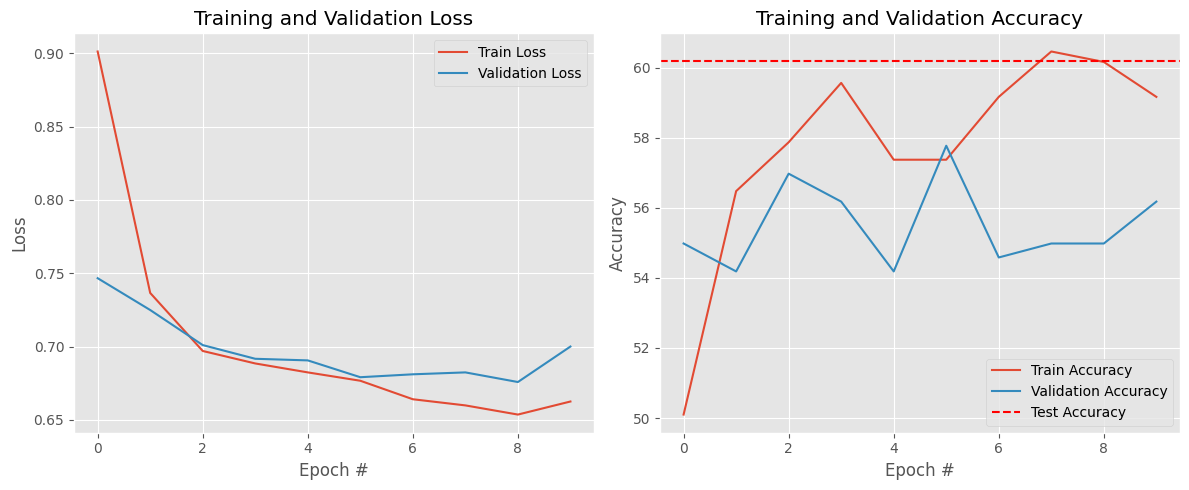

In [ ]:
# train final model
set_random_seed()
dropout_rate = study.best_params.get('dropout_rate') # To optimize
learning_rate = study.best_params.get('learning_rate') # To optimize
batch_size = study.best_params.get('batch_size') # To optimize
model = CNN(dropout_rate) # Optimized parameter
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, testloader = test_loader, verbose = False)

In [ ]:
# save model
torch.save(model, os.path.join(outputdir, study_id + '_model.pth'))

### FCNN-CNN dual-branch neuronal network

In [ ]:
# Parameters to save results
outputdir = '3_DB_1'
study_id = 'db_1'
if not os.path.exists(outputdir):
  os.makedirs(outputdir)

In [ ]:
# Prepare Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

train_dataset = img_meta_Dataset(df_train_proc['engagement'], df_train_proc['main_image_path'], df_train_proc.drop(['engagement','main_image_path'], axis=1), transform = transform)
val_dataset = img_meta_Dataset(df_val_proc['engagement'], df_val_proc['main_image_path'], df_val_proc.drop(['engagement','main_image_path'], axis=1), transform = transform)
test_dataset = img_meta_Dataset(df_test_proc['engagement'], df_test_proc['main_image_path'], df_test_proc.drop(['engagement','main_image_path'], axis=1), transform = transform)

In [ ]:
# Neural network configuration
num_epochs = 10
criterion = nn.CrossEntropyLoss()

Device: cpu
Epoch 1, Loss: 0.8814737647771835, Acc: 55.47808764940239, Val Loss: 0.8194556534290314, Val Acc: 53.78486055776892, LR: 0.01
Epoch 2, Loss: 0.698012188076973, Acc: 65.13944223107569, Val Loss: 0.7355851531028748, Val Acc: 56.97211155378486, LR: 0.01
Epoch 3, Loss: 0.6415577083826065, Acc: 65.63745019920319, Val Loss: 0.6884512901306152, Val Acc: 60.95617529880478, LR: 0.01
Epoch 4, Loss: 0.6231833547353745, Acc: 68.32669322709164, Val Loss: 0.6547657251358032, Val Acc: 59.7609561752988, LR: 0.01
Epoch 5, Loss: 0.6070995554327965, Acc: 67.82868525896414, Val Loss: 0.6460268795490265, Val Acc: 59.7609561752988, LR: 0.01
Epoch 6, Loss: 0.5778506994247437, Acc: 68.32669322709164, Val Loss: 0.6400531232357025, Val Acc: 60.95617529880478, LR: 0.01
Epoch 7, Loss: 0.5723215639591217, Acc: 68.32669322709164, Val Loss: 0.654718667268753, Val Acc: 58.96414342629482, LR: 0.01
Epoch 8, Loss: 0.5782106816768646, Acc: 69.5219123505976, Val Loss: 0.6448518335819244, Val Acc: 62.1513944223

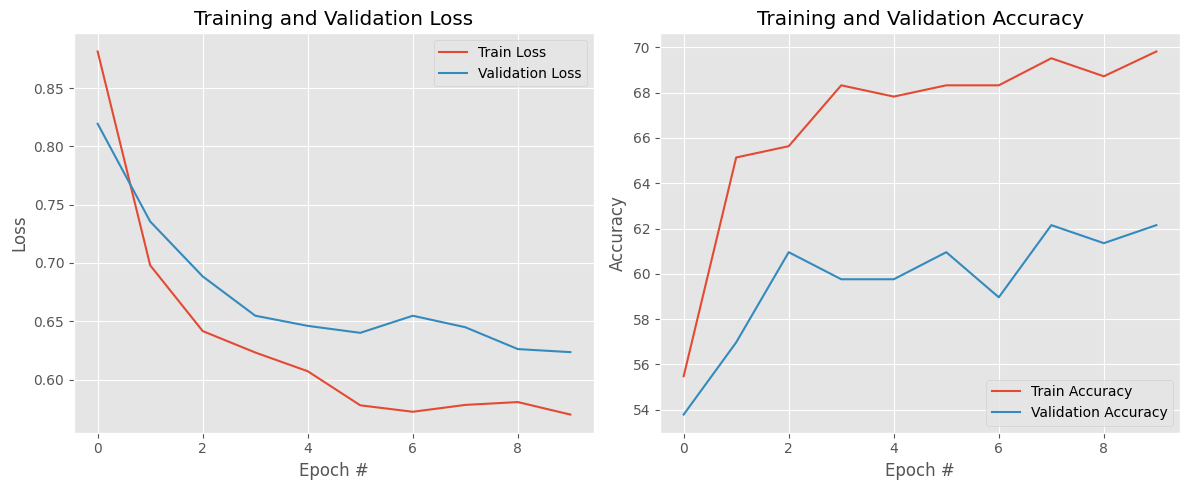

In [ ]:
# train model (check if configuration is ok)
set_random_seed()
learning_rate = 0.01 # To optimize
dropout_rate = 0.2 # To optimize
batch_size = 128 # To optimize
model = dual_branch(dropout_rate) # Optimized parameter
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device)

In [ ]:
def objective(trial, to_optim = None):
    """
    Objective function for hyperparameter optimization with Optuna.
    """

    # seed for random numbers
    set_random_seed()

    # hyperparameters to optimize
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5) # To optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True) # To optimize
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256]) # To optimize

    model = dual_branch(dropout_rate) # Optimized parameter
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter

    # train model
    train_results = train_model(model, criterion, optimizer, num_epochs,
                                train_loader, val_loader, device, verbose = False)

    # save metrics
    save_metrics_optuna(trial, train_results, outputdir)

    return train_results['val_accs'][-1]

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna_init(sampler, outputdir, study_id)

[I 2025-06-14 15:12:10,335] A new study created in RDB with name: db_1_optimization


In [ ]:
# Optuna optimization
n_trials = 24

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=n_trials, show_progress_bar = True)
optuna_results(study)

  0%|          | 0/24 [00:00<?, ?it/s]

Best trial:
  Value:  65.33864541832669
  Params: 
			Value		Importance 
    dropout_rate:	0.46675		0.38
    learning_rate:	0.00828		0.31
    batch_size:	128.00000		0.31


Confussion matrix:
[[ 91  58]
 [ 44 121]]

Classification report
              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64       149
         1.0       0.68      0.73      0.70       165

    accuracy                           0.68       314
   macro avg       0.68      0.67      0.67       314
weighted avg       0.68      0.68      0.67       314

Accuracy score: 0.68


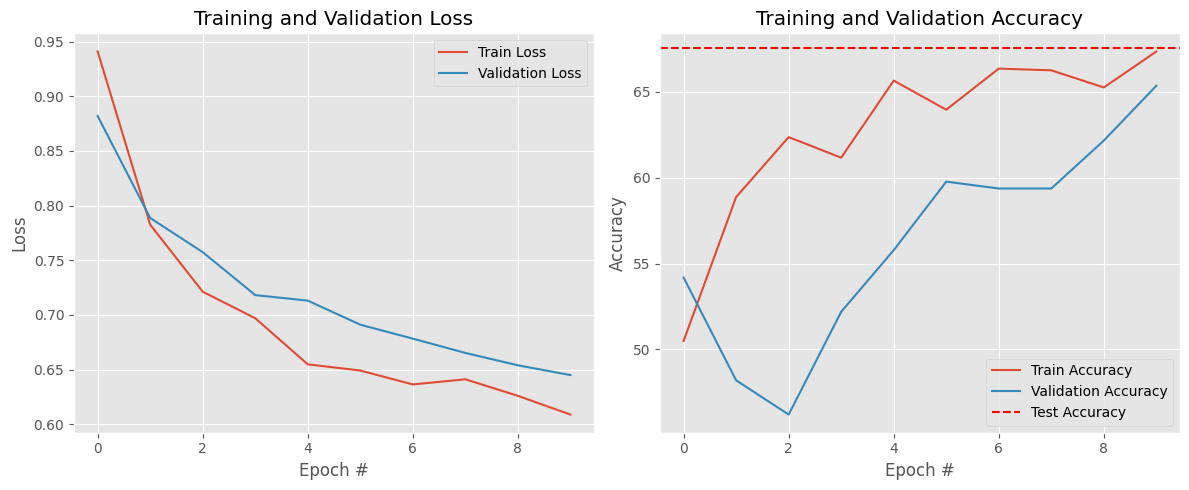

In [ ]:
# train final model
set_random_seed()
dropout_rate = study.best_params.get('dropout_rate') # To optimize
learning_rate = study.best_params.get('learning_rate') # To optimize
batch_size = study.best_params.get('batch_size') # To optimize
model = dual_branch(dropout_rate) # Optimized parameter
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, testloader = test_loader, verbose = False)

In [ ]:
# save model
torch.save(model, os.path.join(outputdir, study_id + '_model.pth'))

### FCNN-CNN dual-branch neuronal network (2)

In [ ]:
# Parameters to save results
outputdir = '3_DB_2'
study_id = 'db_2'
if not os.path.exists(outputdir):
  os.makedirs(outputdir)


In [ ]:
# Prepare Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

train_dataset = img_meta_Dataset(df_train_proc['engagement'], df_train_proc['main_image_path'], df_train_proc.drop(['engagement','main_image_path'], axis=1), transform = transform)
val_dataset = img_meta_Dataset(df_val_proc['engagement'], df_val_proc['main_image_path'], df_val_proc.drop(['engagement','main_image_path'], axis=1), transform = transform)
test_dataset = img_meta_Dataset(df_test_proc['engagement'], df_test_proc['main_image_path'], df_test_proc.drop(['engagement','main_image_path'], axis=1), transform = transform)

In [ ]:
# Neural network configuration
num_epochs = 10
criterion = nn.CrossEntropyLoss()

Device: cuda:0
Epoch 1, Loss: 0.8800514712929726, Acc: 54.28286852589641, Val Loss: 0.7957654297351837, Val Acc: 54.581673306772906, LR: 0.01
Epoch 2, Loss: 0.6993030607700348, Acc: 64.7410358565737, Val Loss: 0.7299613952636719, Val Acc: 52.191235059760956, LR: 0.01
Epoch 3, Loss: 0.6423791199922562, Acc: 66.73306772908367, Val Loss: 0.7265017628669739, Val Acc: 54.18326693227092, LR: 0.01
Epoch 4, Loss: 0.6324473097920418, Acc: 67.82868525896414, Val Loss: 0.6761179566383362, Val Acc: 58.96414342629482, LR: 0.01
Epoch 5, Loss: 0.5936996564269066, Acc: 69.42231075697211, Val Loss: 0.6586409211158752, Val Acc: 62.54980079681275, LR: 0.01
Epoch 6, Loss: 0.5833506211638451, Acc: 69.42231075697211, Val Loss: 0.6368521749973297, Val Acc: 61.354581673306775, LR: 0.01
Epoch 7, Loss: 0.5871769972145557, Acc: 68.72509960159363, Val Loss: 0.6503230333328247, Val Acc: 60.1593625498008, LR: 0.01
Epoch 8, Loss: 0.5790528580546379, Acc: 70.3187250996016, Val Loss: 0.6584650874137878, Val Acc: 64.94

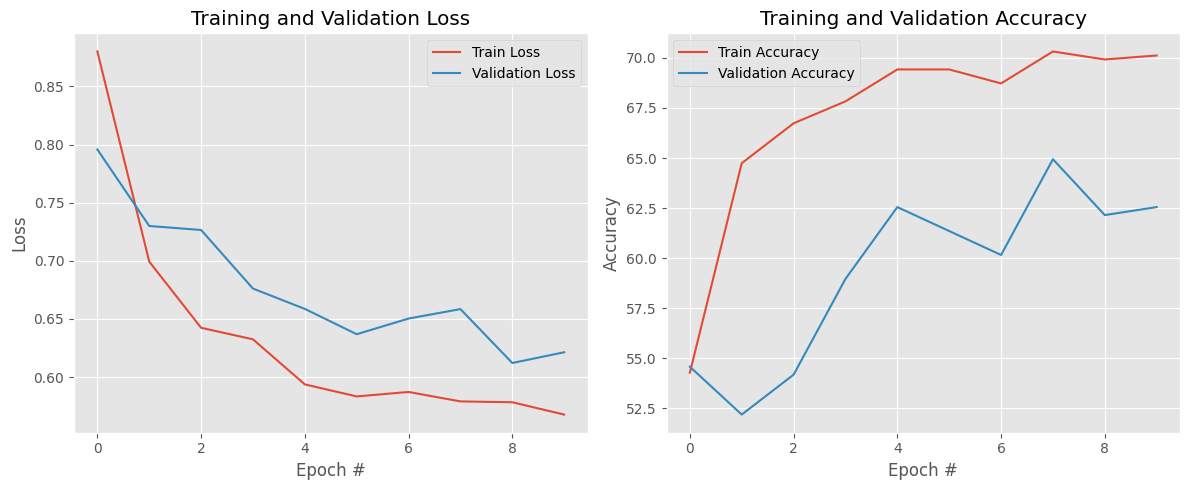

In [ ]:
# train model (check if configuration is ok)
set_random_seed()
learning_rate = 0.01 # To optimize
dropout_rate = 0.2 # To optimize
batch_size = 128 # To optimize
model = dual_branch(dropout_rate) # Optimized parameter
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device)

In [ ]:
def objective(trial, to_optim = None):
    """
    Objective function for hyperparameter optimization with Optuna.
    """

    # seed for random numbers
    set_random_seed()

    # hyperparameters to optimize
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.7) # To optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True) # To optimize
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512]) # To optimize

    model = dual_branch(dropout_rate) # Optimized parameter
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter

    # train model
    train_results = train_model(model, criterion, optimizer, num_epochs,
                                train_loader, val_loader, device, verbose = False)

    # save metrics
    save_metrics_optuna(trial, train_results, outputdir)

    return train_results['val_accs'][-1]

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna_init(sampler, outputdir, study_id)

[I 2025-06-14 20:51:40,949] A new study created in RDB with name: db_2_optimization


In [ ]:
# Optuna optimization
n_trials = 24

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=n_trials, show_progress_bar = True)
optuna_results(study)

  0%|          | 0/24 [00:00<?, ?it/s]

Best trial:
  Value:  65.33864541832669
  Params: 
			Value		Importance 
    dropout_rate:	0.42957		0.53
    learning_rate:	0.04049		0.12
    batch_size:	128.00000		0.35


Confussion matrix:
[[ 96  53]
 [ 45 120]]

Classification report
              precision    recall  f1-score   support

         0.0       0.68      0.64      0.66       149
         1.0       0.69      0.73      0.71       165

    accuracy                           0.69       314
   macro avg       0.69      0.69      0.69       314
weighted avg       0.69      0.69      0.69       314

Accuracy score: 0.69


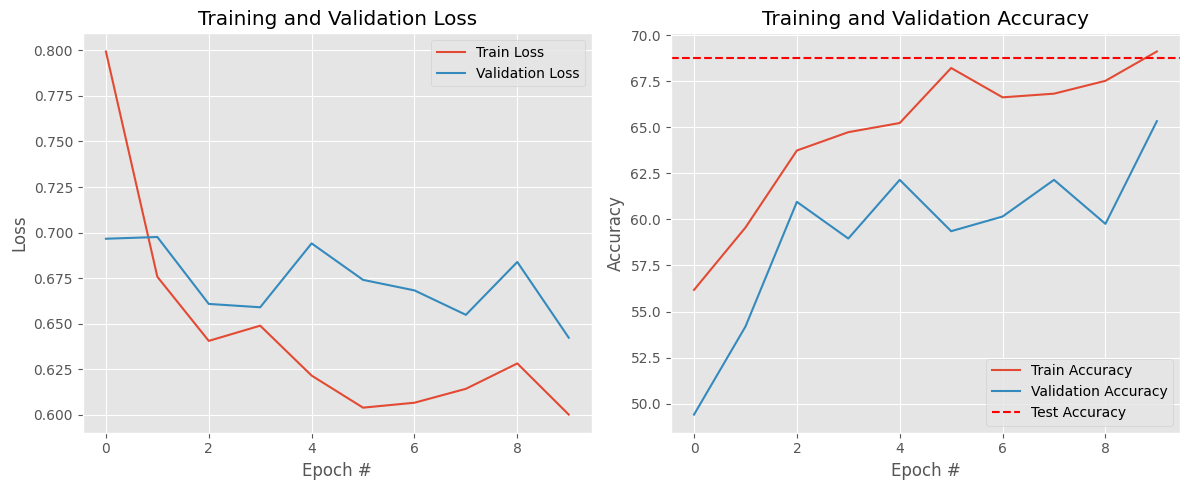

In [ ]:
# train final model
set_random_seed()
dropout_rate = study.best_params.get('dropout_rate') # To optimize
learning_rate = study.best_params.get('learning_rate') # To optimize
batch_size = study.best_params.get('batch_size') # To optimize
model = dual_branch(dropout_rate) # Optimized parameter
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, testloader = test_loader, verbose = False)

In [ ]:
# save model
torch.save(model, os.path.join(outputdir, study_id + '_model.pth'))

### Transfer learning neuronal network (ResNet18)

In [ ]:
# Parameters to save results
outputdir = '4_RN18_1'
study_id = 'rn18_1'
if not os.path.exists(outputdir):
  os.makedirs(outputdir)

In [ ]:
# Prepare Dataset
resnet18 = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

train_dataset = img_meta_resnet_Dataset(df_train_proc['engagement'], df_train_proc['main_image_path'], df_train_proc.drop(['engagement','main_image_path'], axis=1), transform = resnet18)
val_dataset = img_meta_resnet_Dataset(df_val_proc['engagement'], df_val_proc['main_image_path'], df_val_proc.drop(['engagement','main_image_path'], axis=1), transform = resnet18)
test_dataset = img_meta_resnet_Dataset(df_test_proc['engagement'], df_test_proc['main_image_path'], df_test_proc.drop(['engagement','main_image_path'], axis=1), transform = resnet18)

In [ ]:
# Neural network configuration
num_epochs = 10
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda:0
Epoch 1, Loss: 1.0834106430411339, Acc: 56.374501992031874, Val Loss: 0.8977844417095184, Val Acc: 55.776892430278885, LR: 0.01
Epoch 2, Loss: 0.851526752114296, Acc: 57.96812749003984, Val Loss: 0.7315663397312164, Val Acc: 60.55776892430279, LR: 0.01
Epoch 3, Loss: 0.6824987456202507, Acc: 61.45418326693227, Val Loss: 0.7780493199825287, Val Acc: 60.1593625498008, LR: 0.01
Epoch 4, Loss: 0.6251501739025116, Acc: 65.63745019920319, Val Loss: 0.768842339515686, Val Acc: 60.1593625498008, LR: 0.01
Epoch 5, Loss: 0.5977206081151962, Acc: 68.72509960159363, Val Loss: 0.7080917358398438, Val Acc: 58.56573705179283, LR: 0.01
Epoch 6, Loss: 0.5577689781785011, Acc: 70.81673306772909, Val Loss: 0.7293301820755005, Val Acc: 58.56573705179283, LR: 0.01
Epoch 7, Loss: 0.5543398708105087, Acc: 70.91633466135458, Val Loss: 0.7216586470603943, Val Acc: 61.75298804780876, LR: 0.01
Epoch 8, Loss: 0.5569361075758934, Acc: 71.11553784860558, Val Loss: 0.7068750262260437, Val Acc: 61.7529

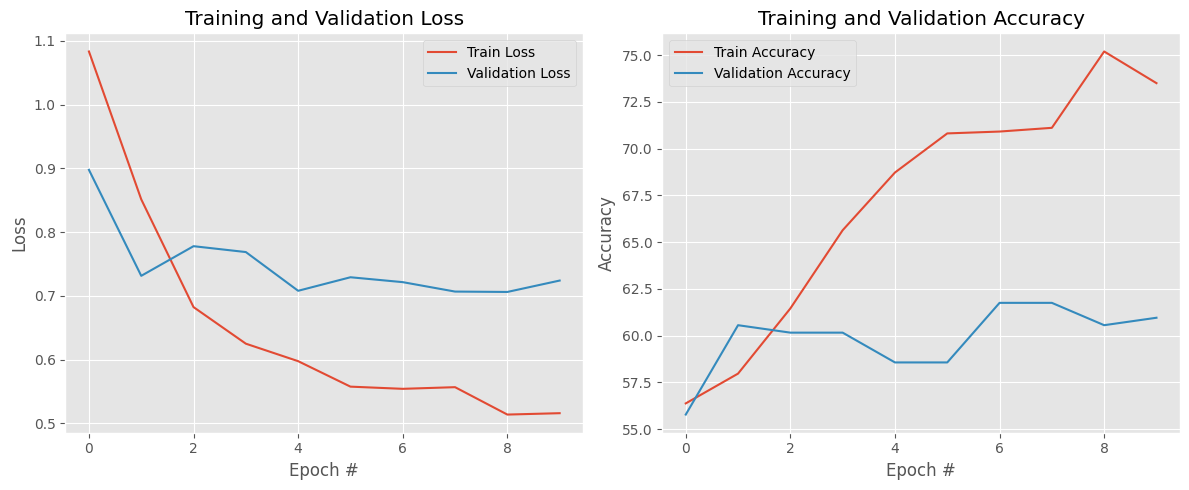

In [ ]:
# train model (check if configuration is ok)
set_random_seed()
learning_rate = 0.01 # To optimize
batch_size = 128 # To optimize
model = CNN_pretrain(ResNet18_class)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device)

In [ ]:
def objective(trial, to_optim = None):
    """
    Objective function for hyperparameter optimization with Optuna.
    """

    # seed for random numbers
    set_random_seed()

    # hyperparameters to optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True) # To optimize
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256]) # To optimize

    model = CNN_pretrain(ResNet18_class)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter

    # train model
    train_results = train_model(model, criterion, optimizer, num_epochs,
                                train_loader, val_loader, device, verbose = False)

    # save metrics
    save_metrics_optuna(trial, train_results, outputdir)

    return train_results['val_accs'][-1]

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna_init(sampler, outputdir, study_id)

In [ ]:
# Optuna optimization
n_trials = 12
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=n_trials, show_progress_bar = True)
optuna_results(study)

  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best trial:
  Value:  64.14342629482071
  Params: 
			Value		Importance 
    learning_rate:	0.01867		0.55
    batch_size:	128.00000		0.45


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Confussion matrix:
[[ 88  61]
 [ 59 106]]

Classification report
              precision    recall  f1-score   support

         0.0       0.60      0.59      0.59       149
         1.0       0.63      0.64      0.64       165

    accuracy                           0.62       314
   macro avg       0.62      0.62      0.62       314
weighted avg       0.62      0.62      0.62       314

Accuracy score: 0.62


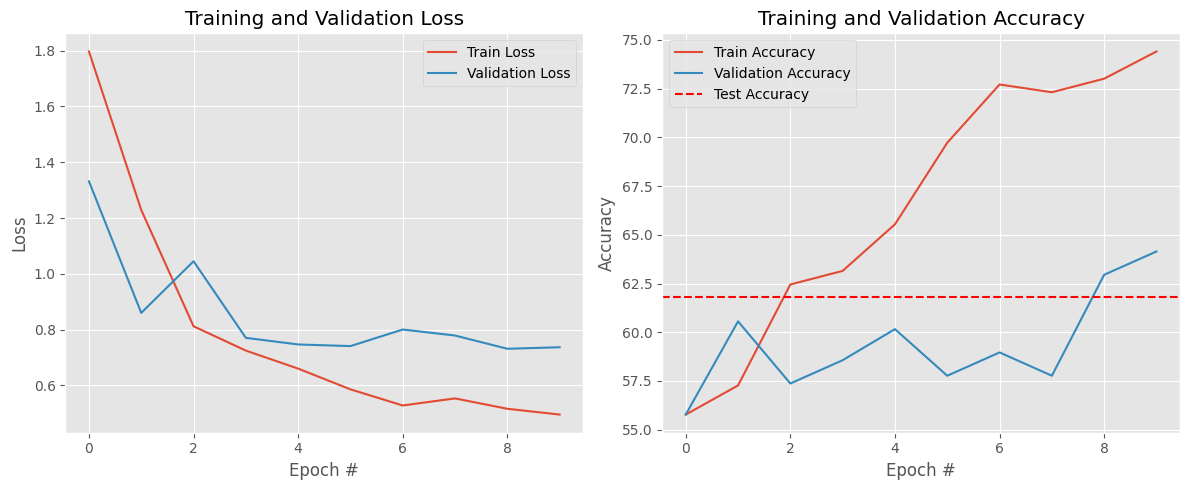

In [ ]:
# train final model
set_random_seed()
learning_rate = study.best_params.get('learning_rate') # To optimize
batch_size = study.best_params.get('batch_size') # To optimize
model = CNN_pretrain(ResNet18_class)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, testloader = test_loader, verbose = False)

In [ ]:
# save model
torch.save(model, os.path.join(outputdir, study_id + '_model.pth'))

### FCNN-ResNet18 dual-branch neuronal network

In [ ]:
# Parameters to save results
outputdir = '5_RN18DB_1'
study_id = 'rn18db_1'
if not os.path.exists(outputdir):
  os.makedirs(outputdir)

In [ ]:
# Prepare Dataset
resnet18 = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

train_dataset = img_meta_resnet_Dataset(df_train_proc['engagement'], df_train_proc['main_image_path'], df_train_proc.drop(['engagement','main_image_path'], axis=1), transform = resnet18)
val_dataset = img_meta_resnet_Dataset(df_val_proc['engagement'], df_val_proc['main_image_path'], df_val_proc.drop(['engagement','main_image_path'], axis=1), transform = resnet18)
test_dataset = img_meta_resnet_Dataset(df_test_proc['engagement'], df_test_proc['main_image_path'], df_test_proc.drop(['engagement','main_image_path'], axis=1), transform = resnet18)

In [ ]:
# Neural network configuration
num_epochs = 10
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


Device: cpu
Epoch 1, Loss: 0.6851922050118446, Acc: 59.36254980079681, Val Loss: 0.6922014355659485, Val Acc: 58.56573705179283, LR: 0.01
Epoch 2, Loss: 0.5712772384285927, Acc: 71.61354581673307, Val Loss: 0.7011515200138092, Val Acc: 61.354581673306775, LR: 0.01
Epoch 3, Loss: 0.54239372164011, Acc: 72.90836653386454, Val Loss: 0.7292204797267914, Val Acc: 58.56573705179283, LR: 0.01
Epoch 4, Loss: 0.49104173108935356, Acc: 76.39442231075697, Val Loss: 0.745486319065094, Val Acc: 58.167330677290835, LR: 0.01
Epoch 5, Loss: 0.4582517221570015, Acc: 78.88446215139442, Val Loss: 0.7875432372093201, Val Acc: 60.1593625498008, LR: 0.01
Epoch 6, Loss: 0.4176510460674763, Acc: 78.98406374501992, Val Loss: 0.828268826007843, Val Acc: 60.95617529880478, LR: 0.01
Epoch 7, Loss: 0.38320981338620186, Acc: 82.17131474103586, Val Loss: 0.864910751581192, Val Acc: 58.56573705179283, LR: 0.01
Epoch 8, Loss: 0.34399377927184105, Acc: 85.0597609561753, Val Loss: 0.76667520403862, Val Acc: 62.151394422

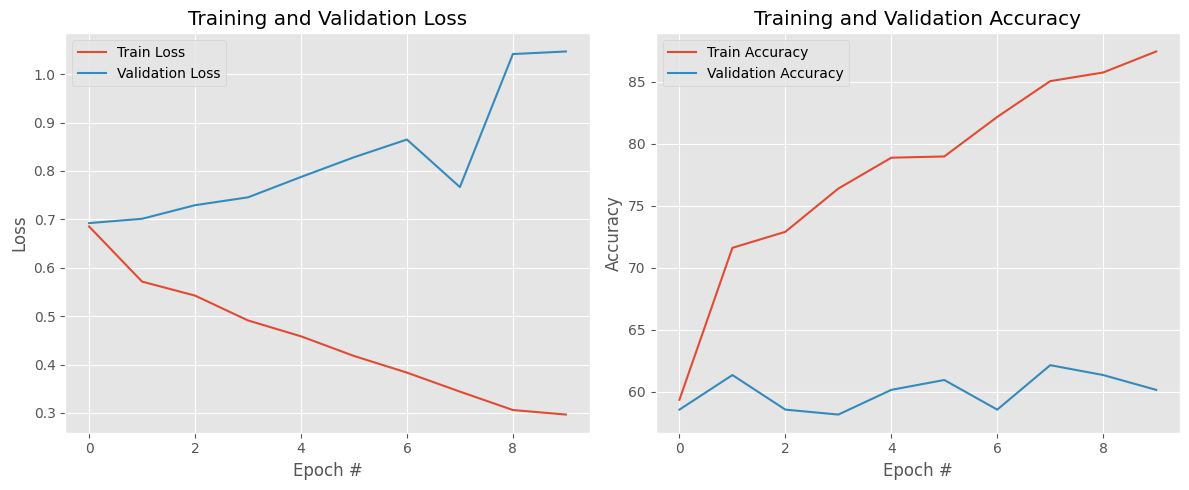

In [ ]:
# train model (check if configuration is ok)
set_random_seed()
learning_rate = 0.01 # To optimize
dropout_rate = 0.2 # To optimize
batch_size = 128 # To optimize
model = dual_branch_ResNet18(dropout_rate) # Optimized parameter
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device)

In [ ]:
def objective(trial, to_optim = None):
    """
    Objective function for hyperparameter optimization with Optuna.
    """

    # seed for random numbers
    set_random_seed()

    # hyperparameters to optimize
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5) # To optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True) # To optimize
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256]) # To optimize

    model = dual_branch_ResNet18(dropout_rate) # Optimized parameter
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter

    # train model
    train_results = train_model(model, criterion, optimizer, num_epochs,
                                train_loader, val_loader, device, verbose = False)

    # save metrics
    save_metrics_optuna(trial, train_results, outputdir)

    return train_results['val_accs'][-1]

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna_init(sampler, outputdir, study_id)

[I 2025-06-14 22:16:50,858] A new study created in RDB with name: rn18db_1_optimization


In [ ]:
# Optuna optimization
n_trials = 24

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=n_trials, show_progress_bar = True)
optuna_results(study)

  0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best trial:
  Value:  65.73705179282868
  Params: 
			Value		Importance 
    dropout_rate:	0.13960		0.37
    learning_rate:	0.04042		0.31
    batch_size:	32.00000		0.32


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Confussion matrix:
[[ 59  90]
 [ 26 139]]

Classification report
              precision    recall  f1-score   support

         0.0       0.69      0.40      0.50       149
         1.0       0.61      0.84      0.71       165

    accuracy                           0.63       314
   macro avg       0.65      0.62      0.60       314
weighted avg       0.65      0.63      0.61       314

Accuracy score: 0.63


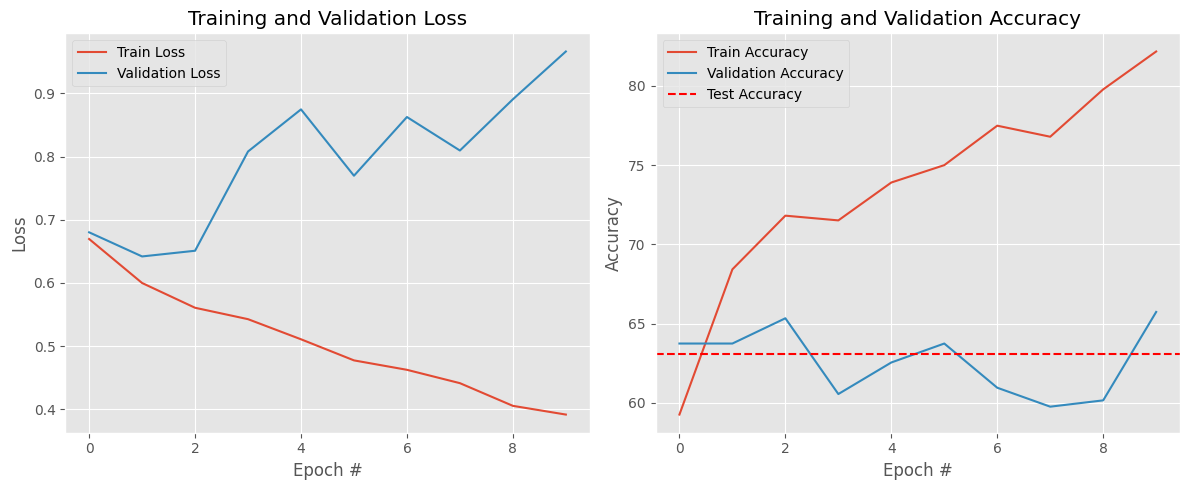

In [ ]:
# train final model
set_random_seed()
dropout_rate = study.best_params.get('dropout_rate') # To optimize
learning_rate = study.best_params.get('learning_rate') # To optimize
batch_size = study.best_params.get('batch_size') # To optimize
model = dual_branch_ResNet18(dropout_rate) # Optimized parameter
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimized parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Optimized parameter
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Optimized parameter
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, testloader = test_loader, verbose = False)

In [ ]:
# save model
torch.save(model, os.path.join(outputdir, study_id + '_model.pth'))